In [69]:
# 모듈 로딩
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image

import shutil
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt


In [70]:
# 원본 데이터셋 경로와 저장 경로 설정
dataset_dir = './img_result/'  # 원본 데이터셋 폴더 경로
train_dir = 'dataset/train/'
val_dir = 'dataset/val/'
test_dir = 'dataset/test/'

In [71]:
# 각 라벨 폴더별로 train, val, test 폴더 생성
def create_directory_structure(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

In [72]:

# 데이터셋 나누기
def split_dataset(dataset_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):
    class_names = os.listdir(dataset_dir)
    
    # 각 라벨에 대해 이미지들을 불러와 train, val, test로 분할
    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_path)
        
        # train, test 나누기
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        # train, val 나누기
        train_images, val_images = train_test_split(train_images, test_size=val_size, random_state=42)
        
        # 폴더 생성
        create_directory_structure(train_dir, class_names)
        create_directory_structure(val_dir, class_names)
        create_directory_structure(test_dir, class_names)
        
        # 이미지 파일을 각각의 폴더로 복사
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))


In [75]:

# 원본 이미지 경로
ROOT_PATH = r'C:\Users\KDP-27\Desktop\KDT6\pj\openCV\img2'
# 수정된 이미지 경로
SAVE_PATH_90 = r'C:\Users\KDP-27\Desktop\KDT6\pj\openCV\img_result'

# ImageFolder 사용
originDS = torchvision.datasets.ImageFolder(root=ROOT_PATH)

# 가우시안 노이즈 추가 함수
def add_gaussian_noise(image, mean=0.0, std=0.1):
    """이미지에 가우시안 노이즈를 추가하는 함수"""
    np_img = np.array(image).astype(np.float32) / 255.0
    noise = np.random.normal(mean, std, np_img.shape)
    noisy_img = np.clip(np_img + noise, 0, 1) * 255
    noisy_img = noisy_img.astype(np.uint8)
    return Image.fromarray(noisy_img)

for i in range(len(originDS)):
    for j in [0, 90, 180, 270]:
        class_name = originDS.classes[originDS[i][1]]
        class_dir = os.path.join(SAVE_PATH_90, class_name)
        
        # 디렉토리가 없는 경우 생성
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        # 파일 경로 설정
        FILE_PATH = os.path.join(class_dir, f'img_index{i}_{j}.jpg')
        FILE_PATH2 = os.path.join(class_dir, f'flip_img_index{i}_{j}.jpg')
        FILE_PATH3 = os.path.join(class_dir, f'noise_img_index{i}_{j}.jpg')

        # 이미지 회전
        rotate_img = originDS[i][0].rotate(j, expand=True)
        # 좌우 반전
        flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
        # 노이즈 추가
        noise_img = add_gaussian_noise(rotate_img)

        # 이미지 저장
        rotate_img.save(FILE_PATH)
        flipped_img.save(FILE_PATH2)
        noise_img.save(FILE_PATH3)

In [76]:
# 실행
split_dataset(dataset_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2)

In [77]:
transforms= transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [78]:
train_dataset=torchvision.datasets.ImageFolder(train_dir, transform=transforms)
test_dataset=torchvision.datasets.ImageFolder(test_dir, transform=transforms)
val_dataset=torchvision.datasets.ImageFolder(val_dir, transform=transforms)

In [79]:
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
test_loader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
val_loader=torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

In [80]:
print(len(train_dataset))

4812


In [81]:
train_dataset.classes

['Huraideok', 'Jji_o', 'cheese_wrap', 'gwak', 'ppitturi']

{0: 'Huraideok', 1: 'Jji_o', 2: 'cheese_wrap', 3: 'gwak', 4: 'ppitturi'}


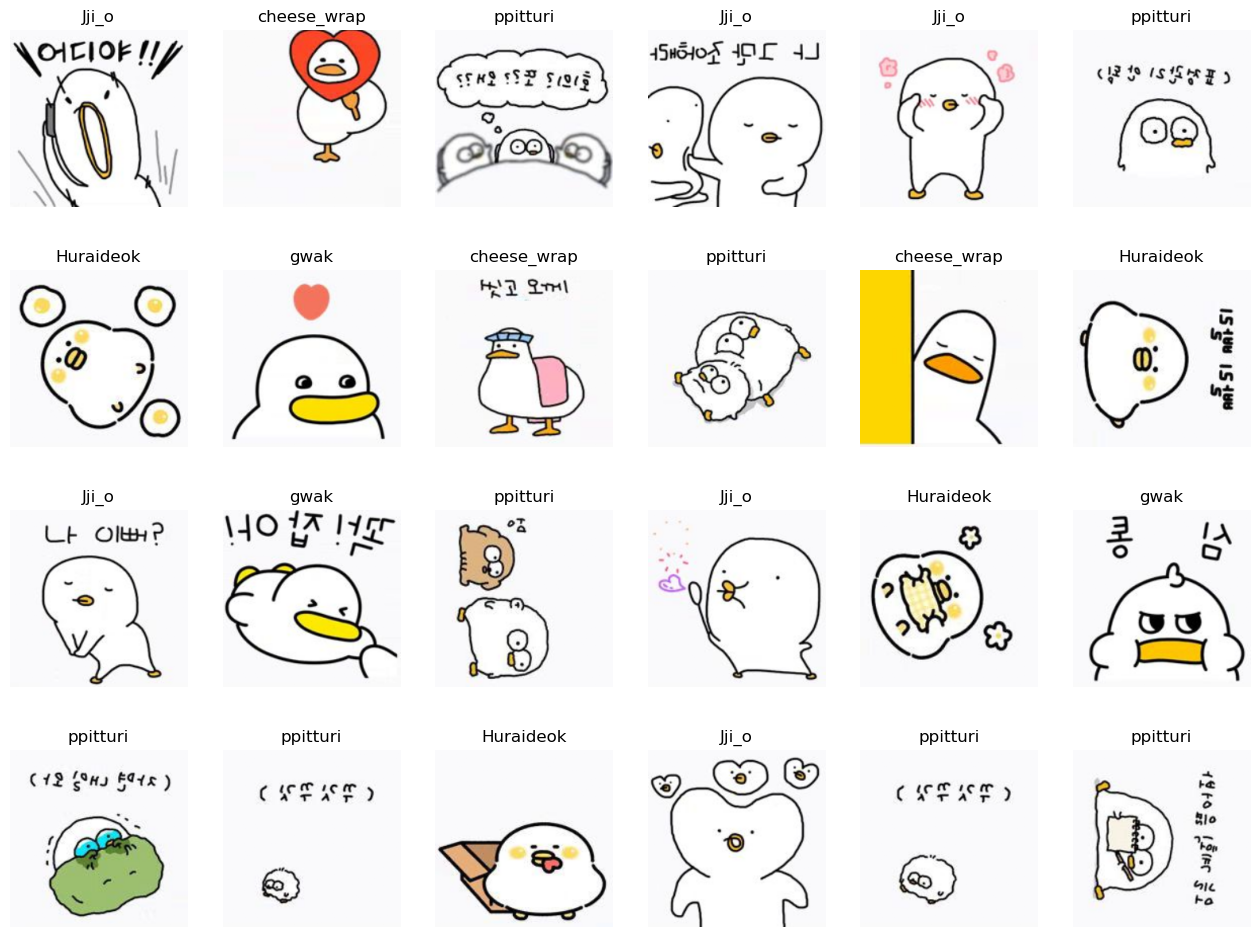

In [82]:
samples, labels = iter(train_loader).__next__()
classes = dict(zip(range(len(train_dataset.classes)), train_dataset.classes))
print(classes)

fig=plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [83]:
# 사전 훈련된 모델 내려받기
resnet18=models.resnet18(pretrained=True) # pretrainde=True : 사전 학습된 가중치를 사용

c:\Users\KDP-27\anaconda3\envs\TORCH_CV_38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KDP-27\anaconda3\envs\TORCH_CV_38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad=False

set_parameter_requires_grad(resnet18)

In [85]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
# ResNet18에 완전연결층 추가
resnet18.fc=nn.Linear(512,5)

In [87]:
# 모델 파라미터 값 확인
for name,param in resnet18.named_parameters(): # 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 1.9106e-02,  1.3723e-02, -1.3035e-02,  ...,  4.1085e-02,
          4.0404e-02, -2.5860e-02],
        [-4.2005e-02, -6.9574e-03,  3.1593e-02,  ...,  3.3823e-02,
         -3.6924e-02, -3.8129e-02],
        [ 8.8417e-03,  3.0971e-02, -1.1433e-02,  ...,  2.4343e-02,
          4.2003e-02,  2.8598e-02],
        [ 1.5093e-02,  1.4527e-02, -3.4335e-02,  ..., -4.2850e-02,
         -1.0194e-02, -1.0154e-02],
        [-4.4162e-02, -8.5849e-03,  2.9514e-02,  ...,  2.8896e-02,
          3.6869e-05, -8.5146e-03]])
fc.bias tensor([ 0.0119, -0.0092,  0.0278, -0.0336, -0.0433])


In [88]:
# 모델 객처 생성 및 손실 함수 정의
model=models.resnet18(pretrained=True) # 모델 객체 생성

for param in model.parameters():    #모델 합성곱층 가중치 고정
    param.requires_grad=False

model.fc=torch.nn.Linear(512,5)
for param in model.fc.parameters(): # 완전연결층 학습
    param.requires_grad = True

optimizer=torch.optim.Adam(model.fc.parameters())
cost=torch.nn.CrossEntropyLoss()    #손실 함수 정의
print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [89]:
def train_model(model, dataloaders, criterion,optimizer,device,num_epochs=13,is_train=True):
    since=time.time()   # 컴퓨터의 현재 시간
    acc_history=[]
    loss_history=[]
    best_acc=0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        running_loss=0.0
        running_corrects=0

        for inputs, labels in dataloaders:  # 데이터로더에 전달된 테이터 만큼 반복
            inputs=inputs.to(device)
            labels=labels.to(device)

            model.to(device)
            optimizer.zero_grad()           # 기울기 0
            outputs=model(inputs)           # 순전파 학습
            loss=criterion(outputs,labels)
            _,preds=torch.max(outputs,1)
            loss.backward()                 # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
        
        epoch_loss= running_loss / len(dataloaders.dataset)     # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)    # 평균 정확도 계산


        print('Loss:{:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_epoch = epoch

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./model/','{0:0=2d}.pth'.format(epoch)))    # 모델 저장

        print()

    time_elapsed = time.time() - since   #실행 시간(학습 시간)을 계산
    print('Traning compleate in {:0f}m {:0f}s'.format(time_elapsed // 60,time_elapsed % 60))
    print('Best Acc: {:4f} at Epoch: {:d}'.format(best_acc, best_epoch))

    return acc_history, loss_history



In [90]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update=[]

for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)      # 파라미터 학습 결과를 저장
        print('\t',name)

optimizer = optim.Adam(params_to_update,lr=0.0001)    # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [91]:
# 1. 데이터셋의 클래스 개수를 파악
num_classes = len(train_loader.dataset.classes)

# 2. ResNet18 모델의 마지막 레이어 수정 (Fully connected layer)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 3. 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    print('cuda')
else:
    print('cpu')

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

# 가중치 초기화
model.apply(initialize_weights)

# 손실 함수 및 최적화 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# 모델 학습
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)


cpu
Epoch 0/12
----------
Loss:0.6054 Acc: 0.8333

Epoch 1/12
----------
Loss:0.2226 Acc: 0.9547

Epoch 2/12
----------
Loss:0.1638 Acc: 0.9672

Epoch 3/12
----------
Loss:0.1403 Acc: 0.9701

Epoch 4/12
----------
Loss:0.1219 Acc: 0.9732

Epoch 5/12
----------
Loss:0.1123 Acc: 0.9761

Epoch 6/12
----------
Loss:0.0983 Acc: 0.9796

Epoch 7/12
----------
Loss:0.0969 Acc: 0.9796

Epoch 8/12
----------
Loss:0.0877 Acc: 0.9815

Epoch 9/12
----------
Loss:0.0843 Acc: 0.9817

Epoch 10/12
----------
Loss:0.0811 Acc: 0.9848

Epoch 11/12
----------
Loss:0.0793 Acc: 0.9830

Epoch 12/12
----------
Loss:0.0706 Acc: 0.9865

Traning compleate in 38.000000m 46.254000s
Best Acc: 0.986492 at Epoch: 12


In [92]:
#데이터 평가 함수 생성
def eval_model(model,dataloaders,device):
    since=time.time()
    acc_history=[]
    best_acc=0.0

    saved_models=glob.glob('./model/'+'*.pth')
    saved_models.sort() # 불러온 pth 파일 정렬
    print('saved_model',saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs=inputs.to(device)
            labels=labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _,preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1 
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()
        epoch_acc = running_corrects.double()/len(dataloaders.dataset)
        print('Acc:{:.4f}'.format(epoch_acc))

        if epoch_acc>best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()
            
    time_elapsed=time.time()-since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history

In [93]:
val_acc_hist=eval_model(resnet18, val_loader, device)

saved_model ['./model\\00.pth', './model\\01.pth', './model\\02.pth', './model\\03.pth', './model\\04.pth', './model\\05.pth', './model\\06.pth', './model\\07.pth', './model\\08.pth', './model\\09.pth', './model\\10.pth', './model\\11.pth', './model\\12.pth']
Loading model ./model\00.pth
Acc:0.3862

Loading model ./model\01.pth
Acc:0.3895

Loading model ./model\02.pth
Acc:0.3895

Loading model ./model\03.pth
Acc:0.3904

Loading model ./model\04.pth
Acc:0.3912

Loading model ./model\05.pth
Acc:0.3929

Loading model ./model\06.pth
Acc:0.3945

Loading model ./model\07.pth
Acc:0.3937

Loading model ./model\08.pth
Acc:0.3945

Loading model ./model\09.pth
Acc:0.3945

Loading model ./model\10.pth
Acc:0.3953

Loading model ./model\11.pth
Acc:0.3945

Loading model ./model\12.pth
Acc:0.3937

Validation complete in 9m 42s
Best Acc: 0.3953


In [94]:
val_acc_hist

[0.3862126245847176,
 0.38953488372093026,
 0.38953488372093026,
 0.3903654485049834,
 0.3911960132890365,
 0.39285714285714285,
 0.3945182724252492,
 0.39368770764119604,
 0.3945182724252492,
 0.3945182724252492,
 0.3953488372093023,
 0.3945182724252492,
 0.39368770764119604]

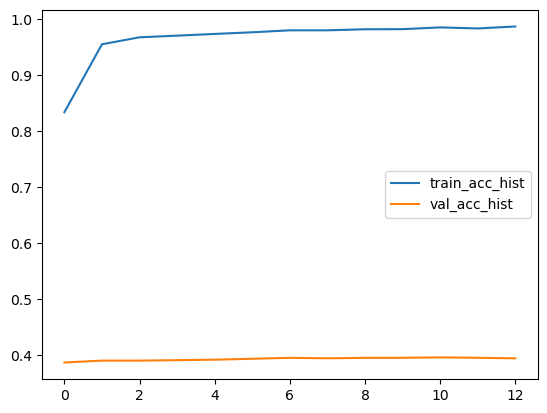

In [95]:
plt.plot(train_acc_hist,label='train_acc_hist')
plt.plot(val_acc_hist,label='val_acc_hist')
plt.legend()
plt.show()

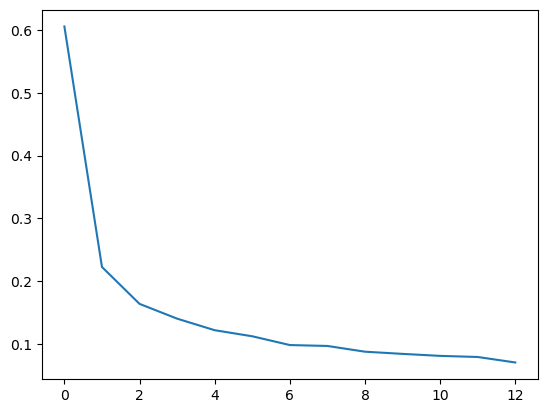

In [96]:
plt.plot(train_loss_hist)
plt.show()

In [97]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

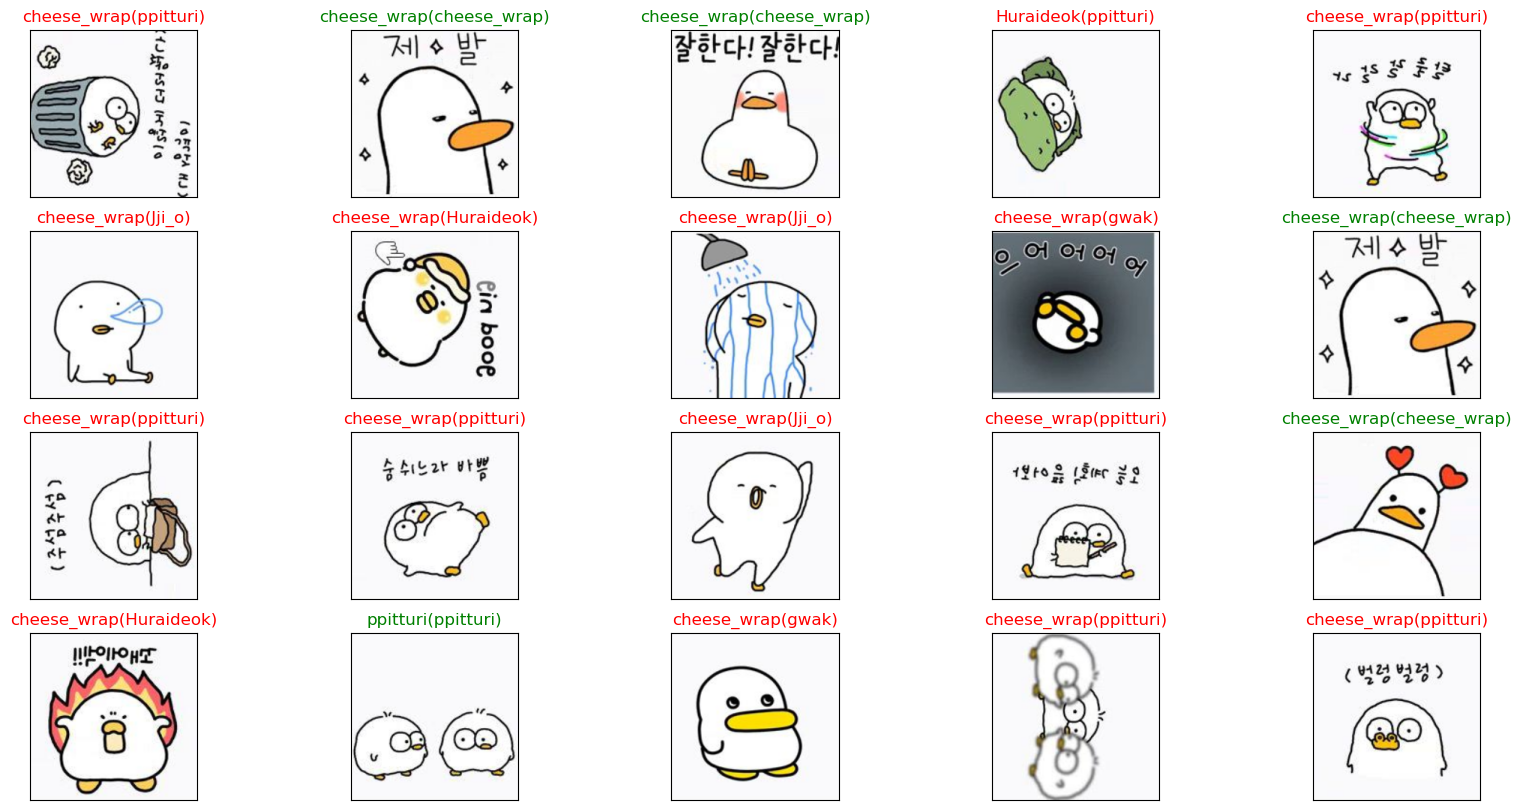

<Figure size 640x480 with 0 Axes>

In [121]:
dataiter=iter(test_loader)
images,labels=dataiter.__next__()
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(20,10))
for idx in np.arange(20):
    ax=fig.add_subplot(4,5,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),
             color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
